In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score


data_dir = "data\ConsumptionData/"
print(os.listdir(data_dir))

['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'est_hourly.paruqet', 'FE_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv']


### Data Preparation

In [67]:
pd.read_csv(data_dir + 'AEP_hourly.csv').head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [2]:
def create_sequence(data, seq_length):
    inputs = np.zeros((len(data)-seq_length,seq_length,1))
    labels = np.zeros(len(data)-seq_length)

    for i in range(seq_length, len(data)):
        inputs[i-seq_length] = data[i-seq_length:i]
        labels[i-seq_length] = data[i,0]
    inputs = inputs.reshape(-1,seq_length,1)
    labels = labels.reshape(-1,1)

    return inputs, labels

In [ ]:
# Load the data    
df = pd.read_csv("C:\iCloudDrive\DataCamp\data\ConsumptionData\AEP_hourly.csv", parse_dates=[0])
df = df.sort_values("Datetime").drop("Datetime",axis=1)

# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
data = sc.fit_transform(df['AEP_MW'].values.reshape(-1,1))
label_sc.fit(df.iloc[:,0].values.reshape(-1,1))

# Creating the sequence data
seq_length = 72
inputs, labels = create_sequence(data, seq_length)

# Splitting the data into training and test sets
test_portion = int(0.1*len(inputs))
train_x = inputs[:-test_portion]
train_y = labels[:-test_portion]
test_x = (inputs[-test_portion:])
test_y = (labels[-test_portion:])

In [4]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(109081, 72, 1) (109081, 1) (12120, 72, 1) (12120, 1)


In [5]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [6]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### LSTM Architecture

In [7]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        # Initialize long-term memory
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        return (h0, c0)

### Training Model

In [ ]:
def train(train_loader, learn_rate, n_layers, hidden_dim, EPOCHS):
    
    input_dim = 1

    # Instantiating the model
    model = LSTMNet(input_dim, hidden_dim, n_layers, 0.2)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    # For plotting afterwords
    losses = []

    model.train()
    print("Starting Training")

    # Start training loop
    for epoch in range(1,EPOCHS+1):
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            
            h = tuple([e.data for e in h])  # Detach hidden state from the computational graph
            optimizer.zero_grad()  # Clear previous gradients
            
            out, h = model(x.to(device).float(), h)  # Forward pass through the model
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            losses.append(loss.item())
            
            if counter%20 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
    return model, losses

In [ ]:
# Hyperparameters

learning_rate = 0.001
n_layers = 2
hidden_dim = 256
epochs = 5

lstm_model, losses = train(train_loader, learning_rate, n_layers, hidden_dim, epochs)

Starting Training
Epoch 1......Step: 20/106....... Average Loss for Epoch: 0.048031250946223736
Epoch 1......Step: 40/106....... Average Loss for Epoch: 0.035463658487424256
Epoch 1......Step: 60/106....... Average Loss for Epoch: 0.029091747663915157
Epoch 1......Step: 80/106....... Average Loss for Epoch: 0.024928619025740773
Epoch 1......Step: 100/106....... Average Loss for Epoch: 0.021682558110915125
Epoch 1/5 Done, Total Loss: 0.02082181620007416
Epoch 2......Step: 20/106....... Average Loss for Epoch: 0.004792577354237437
Epoch 2......Step: 40/106....... Average Loss for Epoch: 0.0038862730609253047
Epoch 2......Step: 60/106....... Average Loss for Epoch: 0.0033254881059595694
Epoch 2......Step: 80/106....... Average Loss for Epoch: 0.002961887283890974
Epoch 2......Step: 100/106....... Average Loss for Epoch: 0.002717000643024221
Epoch 2/5 Done, Total Loss: 0.0026537968342210043
Epoch 3......Step: 20/106....... Average Loss for Epoch: 0.001645758532686159
Epoch 3......Step: 40/

In [59]:
torch.save(lstm_model.state_dict(), 'lstm_model.pth')

### Evaluation

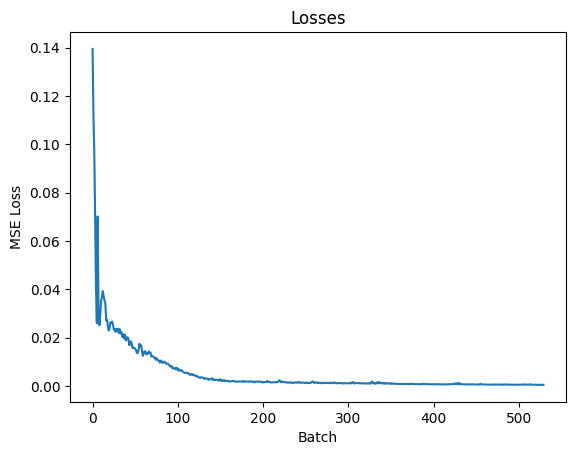

In [62]:
plt.plot(losses, label="Training Loss")
plt.title("Losses")
plt.ylabel("MSE Loss")
plt.xlabel("Batch")
plt.show()

In [ ]:
def evaluate(model, test_x, test_y, label_scaler):
    model.eval()
    outputs = []
    targets = []
    for i, seq in enumerate(test_x):
        inp = torch.from_numpy(np.array(seq)).reshape(1, seq_length, 1)
        labs = torch.from_numpy(np.array(test_y[i])).reshape(1, 1)
        h = model.init_hidden(1)
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scaler.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scaler.inverse_transform(labs.numpy()).reshape(-1))

    r2 = r2_score(targets, outputs)
    print("R^2 Score: {}".format(r2))
    print("R^2 Score: {}".format(r2))
    return outputs, targets

In [ ]:
# Evaluate model with test data
lstm_outputs, targets = evaluate(lstm_model, test_x, test_y, label_sc)

R^2 Score: 0.9789235145441634


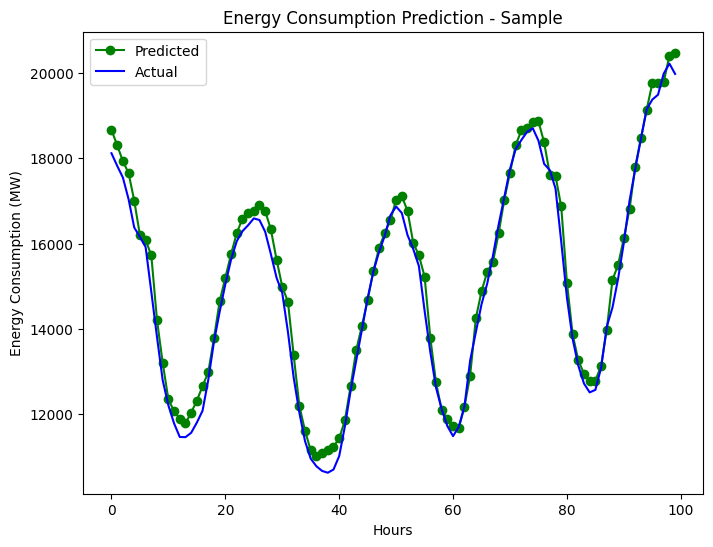

In [51]:
plt.figure(figsize=(8,6))
plt.plot(lstm_outputs[3567:3667], "-o", color="g", label="Predicted")
plt.plot(targets[3567:3667], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.xlabel('Hours')
plt.title('Energy Consumption Prediction - Sample')
plt.legend()
plt.show()